# Precision-Tier Strategy Analysis

**Strategy**: Precision-Tier (Non-Carbon-Aware Baseline)

**Description**: Uses tiered precision allocation with credit balance management, but ignores carbon intensity. This serves as a baseline to measure the impact of carbon-awareness.

## Key Characteristics:
- Fixed tier-based traffic distribution
- Credit balance management without carbon multiplier
- No carbon-aware behavior
- No forecast utilization

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (16, 10)
plt.rcParams['font.size'] = 11

## 1. Load Data

In [4]:
csv_path = 'results/simple_20251113_221636/precision-tier/timeseries.csv'
df = pd.read_csv(csv_path)

# ensure requests_total exists (sum of precision buckets if available, else fallback)
if 'requests_total' not in df.columns:
	if {'requests_precision_30', 'requests_precision_50', 'requests_precision_100'}.issubset(df.columns):
		df['requests_total'] = (
			df['requests_precision_30'] +
			df['requests_precision_50'] +
			df['requests_precision_100']
		)
	elif 'delta_requests' in df.columns:
		df['requests_total'] = df['delta_requests']
	else:
		df['requests_total'] = 0  # fallback if no suitable column available

print(f"Loaded {len(df)} samples")
print(f"Time range: {df['elapsed_seconds'].min():.0f}s to {df['elapsed_seconds'].max():.0f}s")
print(f"Total requests: {df['requests_total'].sum():,.0f}")
df.head()

Loaded 118 samples
Time range: 5s to 603s
Total requests: 272,469


,timestamp,elapsed_seconds,delta_requests,mean_precision,credit_balance,credit_velocity,engine_avg_precision,carbon_now,carbon_next,requests_precision_30,...,queue_depth_p50,queue_depth_p100,replicas_router,replicas_consumer,replicas_target,ceiling_router,ceiling_consumer,ceiling_target,throttle_factor,requests_total
0,2025-11-13T22:17:57.775704Z,5.0,1914,0.8096,-0.3387,-0.0847,0.7469,80.0,120.0,297,...,0,0,0,0,0,NaN,NaN,NaN,0.0,1914
1,2025-11-13T22:18:02.853432Z,10.2,2270,0.7870,-0.3910,-0.0652,0.7208,120.0,160.0,407,...,0,0,0,0,0,NaN,NaN,NaN,0.0,2270
2,2025-11-13T22:18:07.964802Z,15.2,2226,0.7283,-0.3910,-0.0652,0.7208,120.0,160.0,504,...,0,0,0,0,0,NaN,NaN,NaN,0.0,2226
3,2025-11-13T22:18:13.034903Z,20.3,2811,0.7242,-0.3910,-0.0652,0.7208,120.0,160.0,647,...,0,0,0,0,0,NaN,NaN,NaN,0.0,2811
4,2025-11-13T22:18:18.106213Z,25.4,2072,0.7284,-0.4144,-0.0518,0.7099,160.0,200.0,484,...,0,0,0,0,0,NaN,NaN,NaN,0.0,2072


## 2. Calculate Metrics

In [5]:
df['p30_pct'] = (df['requests_precision_30'] / df['requests_total']) * 100
df['p50_pct'] = (df['requests_precision_50'] / df['requests_total']) * 100
df['p100_pct'] = (df['requests_precision_100'] / df['requests_total']) * 100

df['weighted_precision'] = (
    df['requests_precision_30'] * 0.3 +
    df['requests_precision_50'] * 0.5 +
    df['requests_precision_100'] * 1.0
) / df['requests_total']

print("\n=" * 80)
print("PRECISION-TIER STRATEGY SUMMARY")
print("=" * 80)
print(f"\nTotal Requests: {df['requests_total'].sum():,.0f}")
print(f"\nPrecision Distribution:")
print(f"  p30:  {df['requests_precision_30'].sum():>10,.0f} requests ({df['p30_pct'].mean():.1f}% avg)")
print(f"  p50:  {df['requests_precision_50'].sum():>10,.0f} requests ({df['p50_pct'].mean():.1f}% avg)")
print(f"  p100: {df['requests_precision_100'].sum():>10,.0f} requests ({df['p100_pct'].mean():.1f}% avg)")
print(f"\nWeighted Mean Precision: {df['weighted_precision'].mean():.3f}")
print(f"Credit Balance Range: [{df['credit_balance'].min():.3f}, {df['credit_balance'].max():.3f}]")
print(f"Final Credit Balance: {df['credit_balance'].iloc[-1]:.3f}")


=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
PRECISION-TIER STRATEGY SUMMARY

Total Requests: 272,469

Precision Distribution:
  p30:      67,148 requests (24.6% avg)
  p50:      67,183 requests (24.6% avg)
  p100:    138,138 requests (50.7% avg)

Weighted Mean Precision: 0.704
Credit Balance Range: [-0.500, -0.339]
Final Credit Balance: -0.500


## 3. Traffic Distribution Over Time

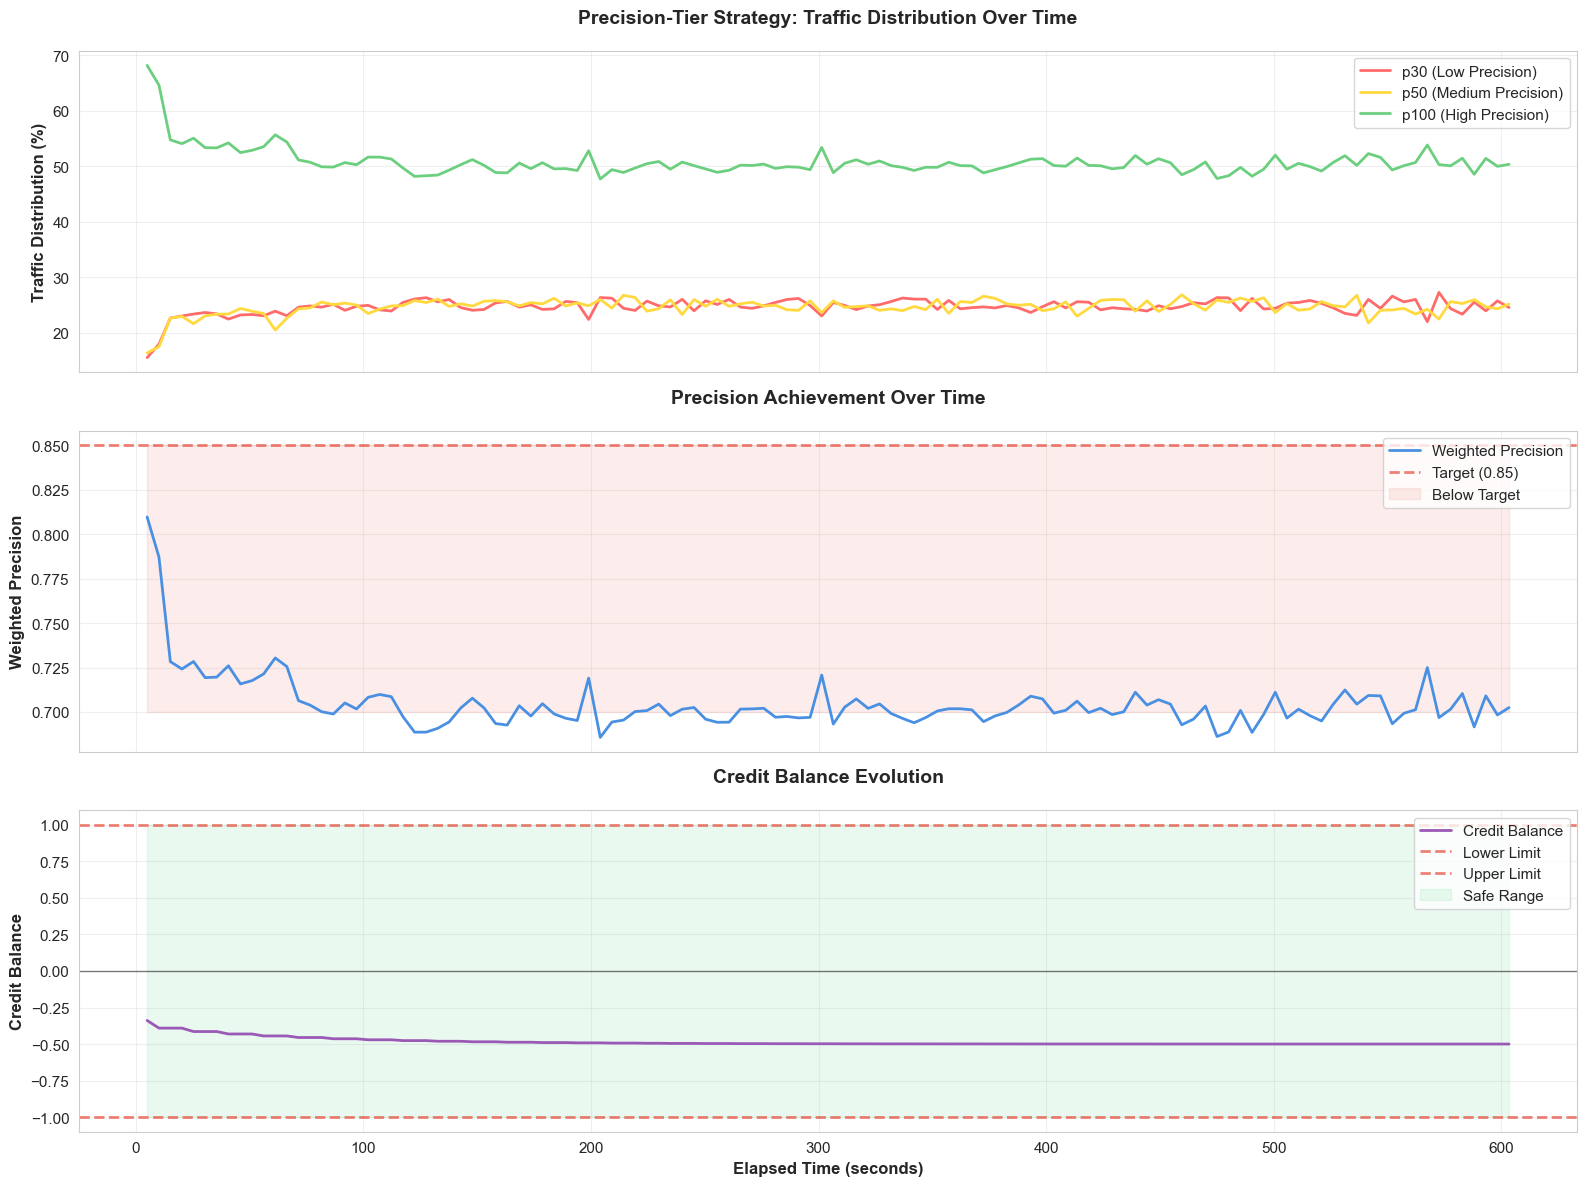

In [6]:
fig, axes = plt.subplots(3, 1, figsize=(16, 12), sharex=True)

axes[0].plot(df['elapsed_seconds'], df['p30_pct'], label='p30 (Low Precision)', color='#ff6b6b', linewidth=2)
axes[0].plot(df['elapsed_seconds'], df['p50_pct'], label='p50 (Medium Precision)', color='#ffd93d', linewidth=2)
axes[0].plot(df['elapsed_seconds'], df['p100_pct'], label='p100 (High Precision)', color='#6bcf7f', linewidth=2)
axes[0].set_ylabel('Traffic Distribution (%)', fontsize=12, fontweight='bold')
axes[0].set_title('Precision-Tier Strategy: Traffic Distribution Over Time', fontsize=14, fontweight='bold', pad=20)
axes[0].legend(loc='upper right', fontsize=11)
axes[0].grid(True, alpha=0.3)

axes[1].plot(df['elapsed_seconds'], df['weighted_precision'], label='Weighted Precision', color='#4a90e2', linewidth=2)
axes[1].axhline(y=0.85, color='#e74c3c', linestyle='--', linewidth=2, label='Target (0.85)', alpha=0.7)
axes[1].fill_between(df['elapsed_seconds'], 0.70, 0.85, color='#e74c3c', alpha=0.1, label='Below Target')
axes[1].set_ylabel('Weighted Precision', fontsize=12, fontweight='bold')
axes[1].set_title('Precision Achievement Over Time', fontsize=14, fontweight='bold', pad=20)
axes[1].legend(loc='upper right', fontsize=11)
axes[1].grid(True, alpha=0.3)

axes[2].plot(df['elapsed_seconds'], df['credit_balance'], label='Credit Balance', color='#9b59b6', linewidth=2)
axes[2].axhline(y=0, color='black', linestyle='-', linewidth=1, alpha=0.5)
axes[2].axhline(y=-1.0, color='#e74c3c', linestyle='--', linewidth=2, label='Lower Limit', alpha=0.7)
axes[2].axhline(y=1.0, color='#e74c3c', linestyle='--', linewidth=2, label='Upper Limit', alpha=0.7)
axes[2].fill_between(df['elapsed_seconds'], -1.0, 1.0, color='#2ecc71', alpha=0.1, label='Safe Range')
axes[2].set_xlabel('Elapsed Time (seconds)', fontsize=12, fontweight='bold')
axes[2].set_ylabel('Credit Balance', fontsize=12, fontweight='bold')
axes[2].set_title('Credit Balance Evolution', fontsize=14, fontweight='bold', pad=20)
axes[2].legend(loc='upper right', fontsize=11)
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Carbon Intensity Response (Should be FLAT)


=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
CARBON RESPONSE (Should be FLAT - No Carbon-Awareness)
                  p100_pct  p50_pct  p30_pct  weighted_precision  carbon_now
carbon_category                                                             
Very Low (<80)        50.6     24.5     24.8                 0.7        60.3
Low (80-160)          51.8     24.1     24.1                 0.7       130.0
High (160-240)        51.6     24.4     24.0                 0.7       212.0
Very High (>240)      49.8     25.2     25.0                 0.7       282.7

📊 p100 Swing (Low vs High Carbon): +0.4pp
✅ CORRECT: No significant carbon-aware behavior (as expected)


/var/folders/wy/spr9sjm92894htwcqvd_ps7c0000gn/T/ipykernel_83552/169562678.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  carbon_response = df.groupby('carbon_category').agg({


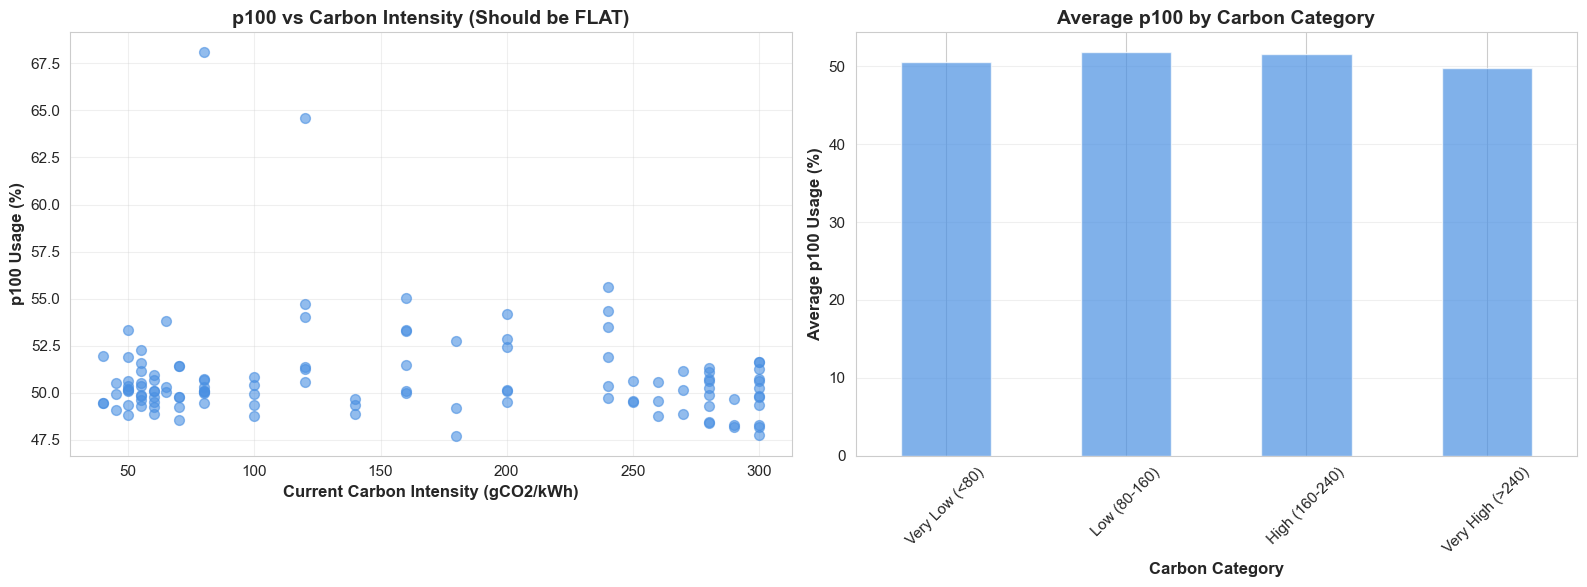

In [7]:
df['carbon_category'] = pd.cut(df['carbon_now'], 
                                bins=[0, 80, 160, 240, 400],
                                labels=['Very Low (<80)', 'Low (80-160)', 'High (160-240)', 'Very High (>240)'])

carbon_response = df.groupby('carbon_category').agg({
    'p100_pct': 'mean',
    'p50_pct': 'mean',
    'p30_pct': 'mean',
    'weighted_precision': 'mean',
    'carbon_now': 'mean'
}).round(1)

print("\n=" * 80)
print("CARBON RESPONSE (Should be FLAT - No Carbon-Awareness)")
print("=" * 80)
print(carbon_response)

low_carbon = df[df['carbon_now'] <= 80]
high_carbon = df[df['carbon_now'] >= 240]

if len(low_carbon) > 0 and len(high_carbon) > 0:
    p100_swing = low_carbon['p100_pct'].mean() - high_carbon['p100_pct'].mean()
    print(f"\n📊 p100 Swing (Low vs High Carbon): {p100_swing:+.1f}pp")
    if abs(p100_swing) < 3:
        print("✅ CORRECT: No significant carbon-aware behavior (as expected)")
    else:
        print("⚠️  WARNING: Unexpected carbon-aware behavior in non-carbon-aware strategy!")
else:
    print("\n⚠️  Insufficient samples in low/high carbon categories")

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].scatter(df['carbon_now'], df['p100_pct'], alpha=0.6, s=50, color='#4a90e2')
axes[0].set_xlabel('Current Carbon Intensity (gCO2/kWh)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('p100 Usage (%)', fontsize=12, fontweight='bold')
axes[0].set_title('p100 vs Carbon Intensity (Should be FLAT)', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

carbon_response['p100_pct'].plot(kind='bar', ax=axes[1], color='#4a90e2', alpha=0.7)
axes[1].set_xlabel('Carbon Category', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Average p100 Usage (%)', fontsize=12, fontweight='bold')
axes[1].set_title('Average p100 by Carbon Category', fontsize=14, fontweight='bold')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 5. Commanded Weights Analysis

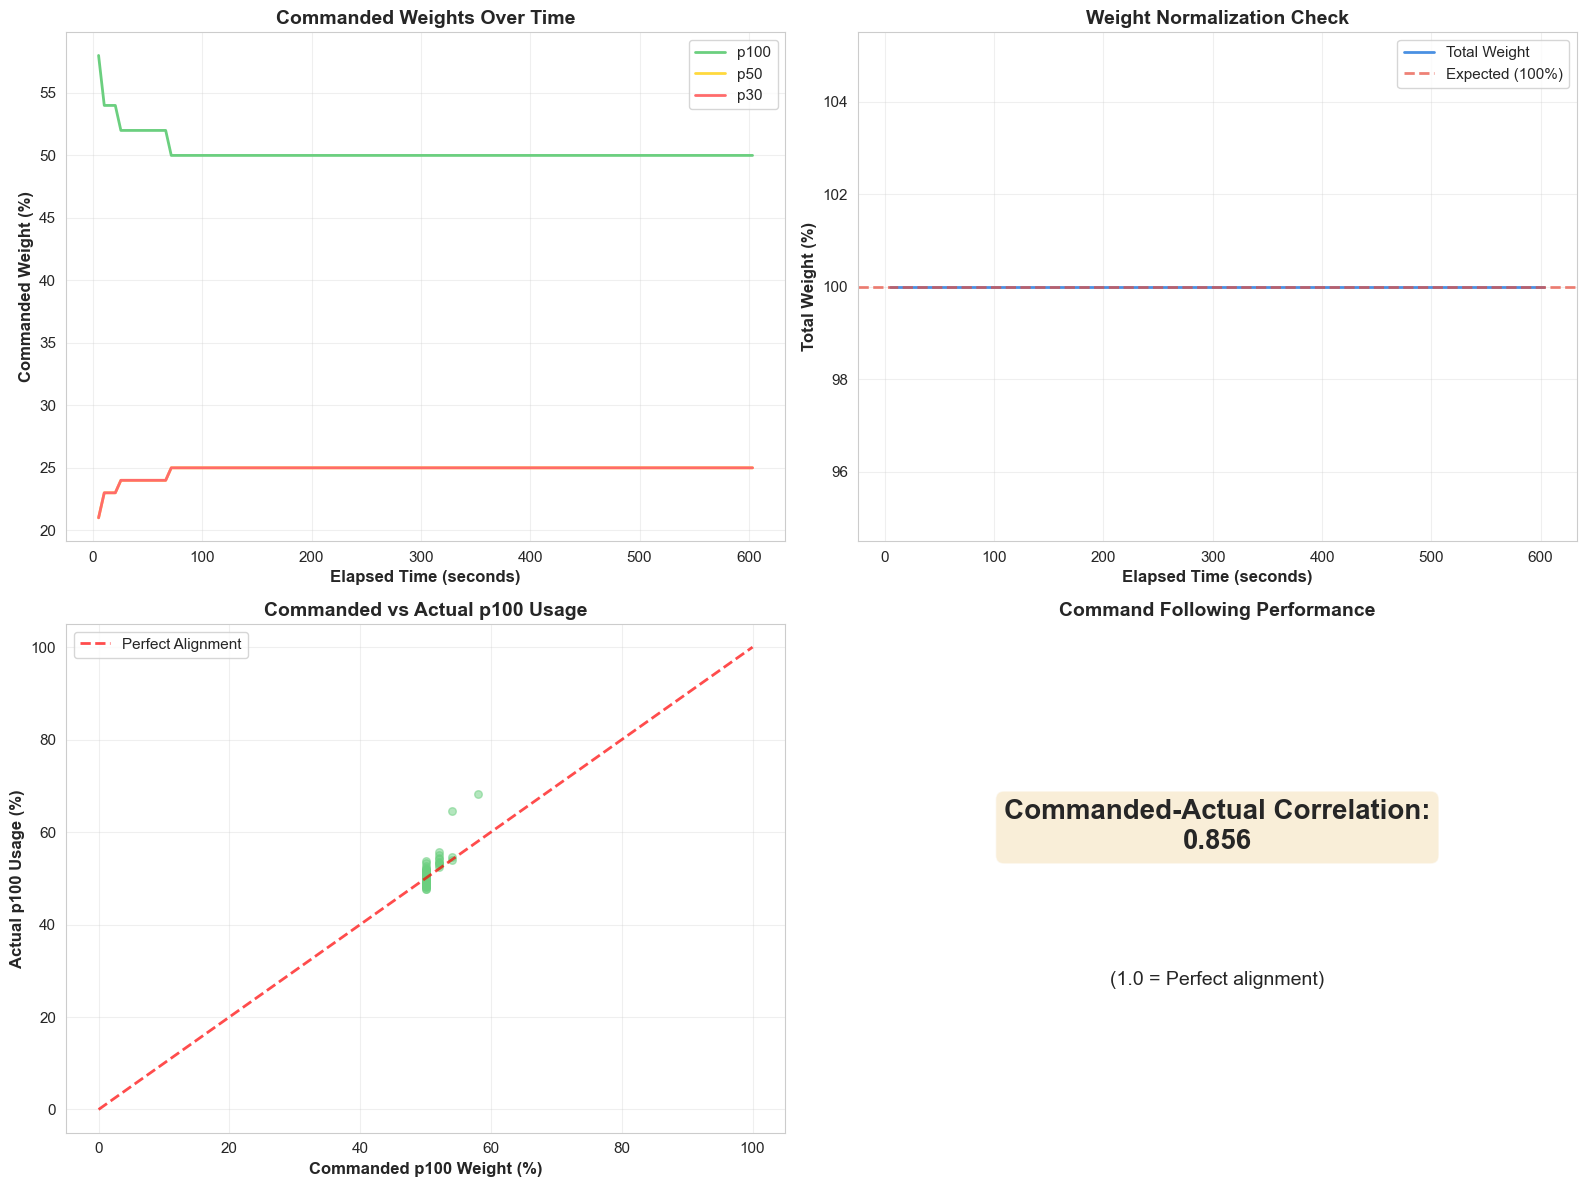


Commanded-Actual Correlation: 0.856
✓ GOOD: Router generally follows decision engine commands


In [8]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

axes[0, 0].plot(df['elapsed_seconds'], df['commanded_weight_100'], label='p100', color='#6bcf7f', linewidth=2)
axes[0, 0].plot(df['elapsed_seconds'], df['commanded_weight_50'], label='p50', color='#ffd93d', linewidth=2)
axes[0, 0].plot(df['elapsed_seconds'], df['commanded_weight_30'], label='p30', color='#ff6b6b', linewidth=2)
axes[0, 0].set_ylabel('Commanded Weight (%)', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Elapsed Time (seconds)', fontsize=12, fontweight='bold')
axes[0, 0].set_title('Commanded Weights Over Time', fontsize=14, fontweight='bold')
axes[0, 0].legend(loc='upper right', fontsize=11)
axes[0, 0].grid(True, alpha=0.3)

weight_total = df['commanded_weight_100'] + df['commanded_weight_50'] + df['commanded_weight_30']
axes[0, 1].plot(df['elapsed_seconds'], weight_total, label='Total Weight', color='#4a90e2', linewidth=2)
axes[0, 1].axhline(y=100, color='#e74c3c', linestyle='--', linewidth=2, label='Expected (100%)', alpha=0.7)
axes[0, 1].set_ylabel('Total Weight (%)', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Elapsed Time (seconds)', fontsize=12, fontweight='bold')
axes[0, 1].set_title('Weight Normalization Check', fontsize=14, fontweight='bold')
axes[0, 1].legend(loc='upper right', fontsize=11)
axes[0, 1].grid(True, alpha=0.3)

axes[1, 0].scatter(df['commanded_weight_100'], df['p100_pct'], alpha=0.5, s=30, color='#6bcf7f')
axes[1, 0].plot([0, 100], [0, 100], 'r--', linewidth=2, label='Perfect Alignment', alpha=0.7)
axes[1, 0].set_xlabel('Commanded p100 Weight (%)', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Actual p100 Usage (%)', fontsize=12, fontweight='bold')
axes[1, 0].set_title('Commanded vs Actual p100 Usage', fontsize=14, fontweight='bold')
axes[1, 0].legend(loc='upper left', fontsize=11)
axes[1, 0].grid(True, alpha=0.3)

correlation = df[['commanded_weight_100', 'p100_pct']].corr().iloc[0, 1]
axes[1, 1].text(0.5, 0.6, f"Commanded-Actual Correlation:\n{correlation:.3f}", 
                ha='center', va='center', fontsize=20, fontweight='bold',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
axes[1, 1].text(0.5, 0.3, "(1.0 = Perfect alignment)", 
                ha='center', va='center', fontsize=14)
axes[1, 1].axis('off')
axes[1, 1].set_title('Command Following Performance', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\nCommanded-Actual Correlation: {correlation:.3f}")
if correlation > 0.9:
    print("✅ EXCELLENT: Router follows decision engine commands very closely")
elif correlation > 0.7:
    print("✓ GOOD: Router generally follows decision engine commands")
else:
    print("⚠️  WARNING: Poor correlation between commanded and actual traffic")

## 6. Key Findings Summary

In [9]:
print("=" * 80)
print("KEY FINDINGS: PRECISION-TIER STRATEGY")
print("=" * 80)
print()
print("1. TRAFFIC DISTRIBUTION:")
print(f"   - Average p30: {df['p30_pct'].mean():.1f}%")
print(f"   - Average p50: {df['p50_pct'].mean():.1f}%")
print(f"   - Average p100: {df['p100_pct'].mean():.1f}%")
print()
print("2. PRECISION ACHIEVEMENT:")
print(f"   - Weighted mean precision: {df['weighted_precision'].mean():.3f}")
print(f"   - Target precision: 0.850")
if df['weighted_precision'].mean() < 0.70:
    print("   - Status: ❌ BELOW TARGET (may indicate credit debt issues)")
elif df['weighted_precision'].mean() < 0.85:
    print("   - Status: ⚠️  BELOW TARGET (conservative to manage credit)")
else:
    print("   - Status: ✅ AT OR ABOVE TARGET")
print()
print("3. CREDIT BALANCE:")
print(f"   - Range: [{df['credit_balance'].min():.3f}, {df['credit_balance'].max():.3f}]")
print(f"   - Final: {df['credit_balance'].iloc[-1]:.3f}")
print(f"   - Stability: σ = {df['credit_balance'].std():.3f}")
if df['credit_balance'].min() < -1.0 or df['credit_balance'].max() > 1.0:
    print("   - Status: ❌ EXCEEDED LIMITS (instability)")
elif abs(df['credit_balance'].iloc[-1]) > 0.5:
    print("   - Status: ⚠️  HIGH FINAL BALANCE (may need rebalancing)")
else:
    print("   - Status: ✅ STABLE within limits")
print()
print("4. CARBON-AWARENESS:")
if len(low_carbon) > 0 and len(high_carbon) > 0:
    print(f"   - p100 usage at low carbon: {low_carbon['p100_pct'].mean():.1f}%")
    print(f"   - p100 usage at high carbon: {high_carbon['p100_pct'].mean():.1f}%")
    print(f"   - Carbon-aware swing: {p100_swing:+.1f}pp")
    if abs(p100_swing) < 3:
        print("   - Status: ✅ NO carbon-aware behavior (as expected for baseline)")
    else:
        print("   - Status: ⚠️  Unexpected variation (may be due to credit dynamics)")
else:
    print("   - Status: ⚠️  Insufficient data to assess")
print()
print("5. COMMAND FOLLOWING:")
print(f"   - Commanded-Actual correlation: {correlation:.3f}")
if correlation > 0.9:
    print("   - Status: ✅ EXCELLENT alignment")
elif correlation > 0.7:
    print("   - Status: ✓ GOOD alignment")
else:
    print("   - Status: ⚠️  POOR alignment (investigate routing issues)")
print()
print("=" * 80)
print("CONCLUSION:")
print("=" * 80)
print()
print("The precision-tier strategy serves as a NON-CARBON-AWARE BASELINE.")
print("It demonstrates traffic management with credit balance control, but")
print("shows no response to carbon intensity variations. This provides a")
print("reference point for measuring the effectiveness of carbon-aware strategies.")
print()
print("Expected behavior:")
print("  ✓ Stable traffic distribution")
print("  ✓ Credit balance management")
print("  ✓ NO carbon-aware swing")
print("  ✓ Serves as baseline for comparison")
print("=" * 80)

KEY FINDINGS: PRECISION-TIER STRATEGY

1. TRAFFIC DISTRIBUTION:
   - Average p30: 24.6%
   - Average p50: 24.6%
   - Average p100: 50.7%

2. PRECISION ACHIEVEMENT:
   - Weighted mean precision: 0.704
   - Target precision: 0.850
   - Status: ⚠️  BELOW TARGET (conservative to manage credit)

3. CREDIT BALANCE:
   - Range: [-0.500, -0.339]
   - Final: -0.500
   - Stability: σ = 0.029
   - Status: ✅ STABLE within limits

4. CARBON-AWARENESS:
   - p100 usage at low carbon: 50.6%
   - p100 usage at high carbon: 50.2%
   - Carbon-aware swing: +0.4pp
   - Status: ✅ NO carbon-aware behavior (as expected for baseline)

5. COMMAND FOLLOWING:
   - Commanded-Actual correlation: 0.856
   - Status: ✓ GOOD alignment

CONCLUSION:

The precision-tier strategy serves as a NON-CARBON-AWARE BASELINE.
It demonstrates traffic management with credit balance control, but
shows no response to carbon intensity variations. This provides a
reference point for measuring the effectiveness of carbon-aware strategies